In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from plotly.offline import plot
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import adjusted_rand_score

from utils import save_plotly_figure_as_html
from ex_01_read_data import get_welding_data
from ex_03_feature_extraction import extract_features
from ex_04_my_kmeans import MyKMeans


In [2]:
data_path = Path("data/Welding/data.csv")
plot_path = Path("plots/ex_04")
plot_path.mkdir(parents=True, exist_ok=True)


data, labels, exp_ids = get_welding_data(data_path, n_samples=5_000)

## Exercise 4.2: Optimal Cluster Selection

Implement the elbow method to find the optimal number of clusters for the raw time series data using your implement of the kmeans algorithm (MyKMeans).

1. Calculate the distortion (inertia) for different values of k (1 to 10)
2. Plot the results to identify the "elbow point" with matplotlib where adding more clusters produces diminishing returns
3. This will help determine the most appropriate number of clusters for our welding data

Fitting MyKMeans for k = 1


Fitting:   1%|          | 1/100 [00:00<00:02, 41.08it/s]


Fitting MyKMeans for k = 2


Fitting:   5%|▌         | 5/100 [00:00<00:01, 69.06it/s]


Fitting MyKMeans for k = 3


Fitting:  21%|██        | 21/100 [00:00<00:01, 58.11it/s]


Fitting MyKMeans for k = 4


Fitting:  11%|█         | 11/100 [00:00<00:01, 44.51it/s]


Fitting MyKMeans for k = 5


Fitting:  42%|████▏     | 42/100 [00:01<00:01, 38.39it/s]


Fitting MyKMeans for k = 6


Fitting:  47%|████▋     | 47/100 [00:01<00:01, 33.19it/s]


Fitting MyKMeans for k = 7


Fitting:  41%|████      | 41/100 [00:01<00:02, 27.72it/s]


Fitting MyKMeans for k = 8


Fitting:  40%|████      | 40/100 [00:01<00:02, 24.61it/s]


Fitting MyKMeans for k = 9


Fitting:  24%|██▍       | 24/100 [00:01<00:03, 19.82it/s]


Fitting MyKMeans for k = 10


Fitting:  51%|█████     | 51/100 [00:02<00:02, 18.29it/s]


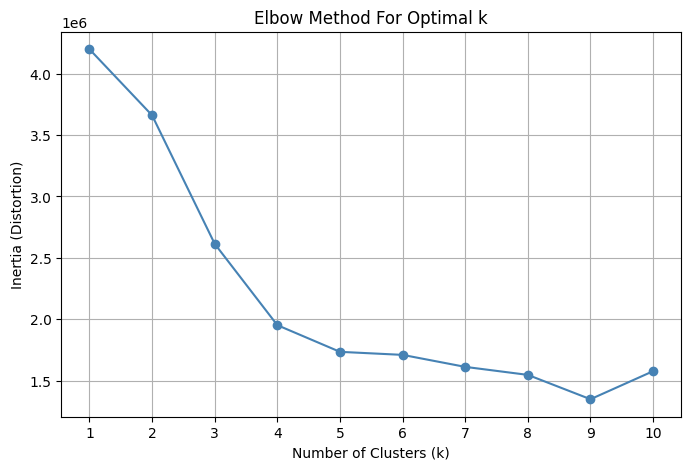

In [36]:
def elbow_method(X, max_clusters=10, distance_metric="euclidean"):
    """
    Apply the elbow method to find the optimal number of clusters.
    
    Args:
        X: Feature matrix (scaled)
        max_clusters: Maximum number of clusters to try
        distance_metric: Distance metric to use
    """
    inertias = []  # Will store the total within-cluster sum of distances (inertia) for each k
    cluster_range = range(1, max_clusters + 1)

    # Run MyKMeans for different values of k and collect the resulting inertia
    for k in cluster_range:
        print(f"Fitting MyKMeans for k = {k}")
        model = MyKMeans(k, distance_metric=distance_metric)
        model.fit(X)
        inertias.append(model.inertia_)

    # Plot using matplotlib: x-axis is k, y-axis is inertia (distortion)
    plt.figure(figsize=(8, 5))
    plt.plot(cluster_range, inertias, marker='o', linestyle='-', color='steelblue')
    plt.title("Elbow Method For Optimal k")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Distortion)")
    plt.xticks(cluster_range)
    plt.grid(True)
    plt.show()

elbow_method(data)

## Exercise 4.3: Clustering with MyKMeans

### Based on the elbow curve above, explain your choice of k:

1. What does the shape of the elbow curve tell you about the underlying data structure?
2. Why did you select this specific number of clusters?
   - Consider the plot and the elbow method to justify your choice
   - How might this choice affect the interpretability of the resulting clusters?

### KMeans with euclidean distance and dtw distance
1. run K means with you selected k 


In [ ]:
"""
The elbow curve shows a sharp drop in inertia up to k = 6, after which the decrease becomes more gradual. 
It is easier to analyze patterns and differences in welding behavior across groups with 6 clusters.
"""

k_optimal = 6  # chosen from elbow plot

def get_inertia(X, k, distance_metric):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(data.reshape(data.shape[0], -1))
    model = MyKMeans(k, distance_metric=distance_metric)
    model.fit(X_scaled)
    return model.inertia_

print("Inertia (Euclidean):", get_inertia(data, k_optimal, "euclidean"))
print("Inertia (DTW):", get_inertia(data, k_optimal, "dtw"))

## Exercise 4.4: Cluster Visualization

Plot the mean time series (centroids) for each cluster to visualize and understand the patterns.

Remember that our welding data has both current and voltage measurements over time (shape: n_samples, sequence_length, features). For each cluster:
1. Plot the average current pattern
2. Plot the average voltage pattern
3. Look for distinctive characteristics in each cluster that might relate to welding quality

This visualization will help identify what makes each cluster unique in terms of temporal patterns.

Fitting:  36%|███▌      | 36/100 [00:01<00:02, 31.01it/s]


Saved plot to plots/ex_04/cluster_current_patterns.png


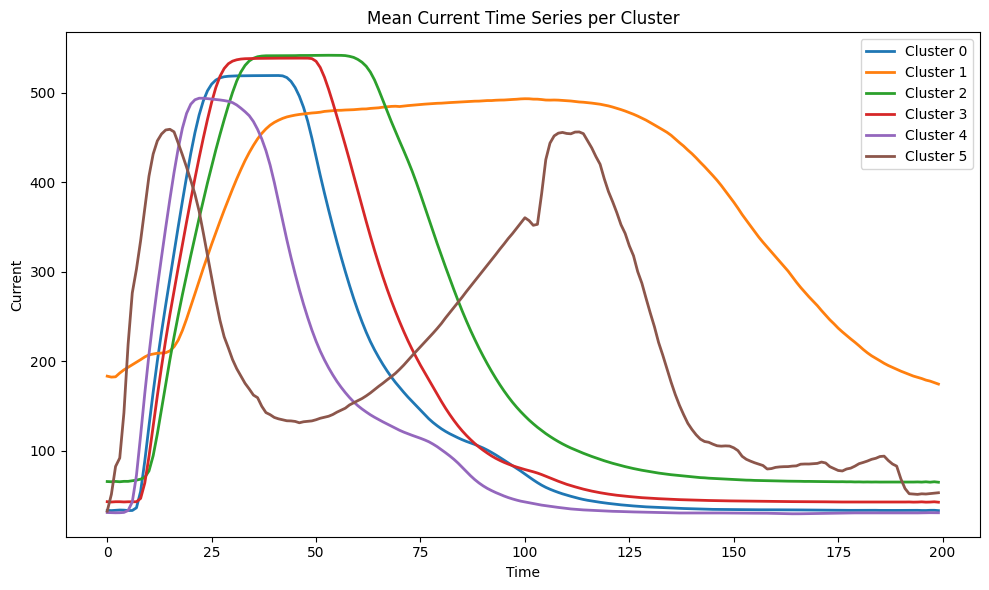

Saved plot to plots/ex_04/cluster_voltage_patterns.png


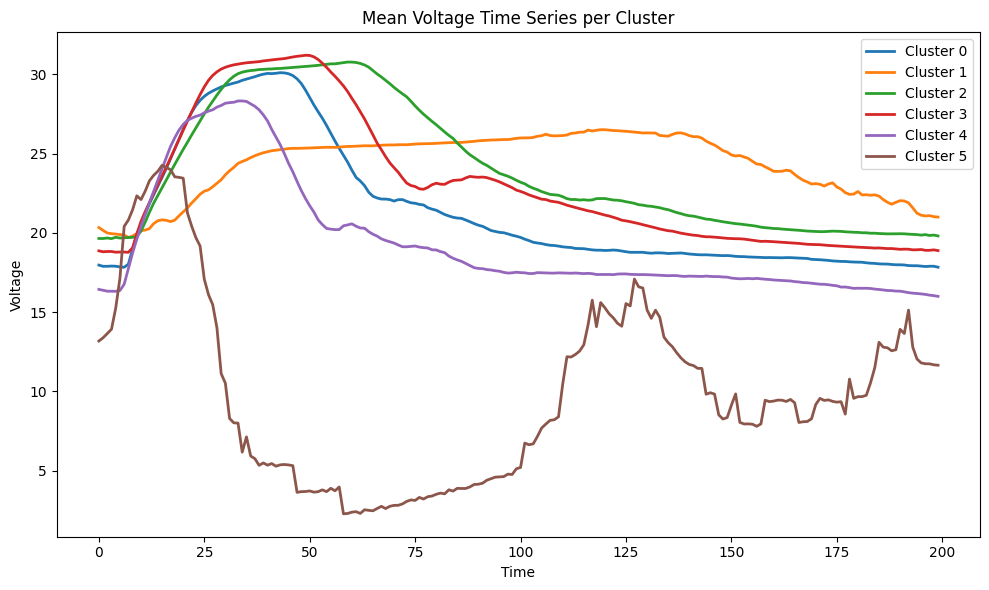

In [35]:
def plot_cluster_centroids(model, feature_names=("Current", "Voltage")):
    centroids = model.centroids  # shape: (k, seq_len, 2)
    k, seq_len, n_features = centroids.shape

    time = np.arange(seq_len)  # x-axis for time series

    for f_idx in range(n_features):
        plt.figure(figsize=(10, 6))

        for cluster_id in range(k):
            # Plot the time series for the current feature
            plt.plot(
                time,
                centroids[cluster_id, :, f_idx],
                label=f"Cluster {cluster_id}",
                linewidth=2
            )

        plt.title(f"Mean {feature_names[f_idx]} Time Series per Cluster")
        plt.xlabel("Time")
        plt.ylabel(feature_names[f_idx])
        plt.legend()
        plt.tight_layout()

        filename = plot_path / f"cluster_{feature_names[f_idx].lower()}_patterns.png"
        plt.savefig(filename)
        print(f"Saved plot to {filename}")
        plt.show()

model = MyKMeans(6)
model.fit(data)

plot_cluster_centroids(model)

## Exercise 4.5: Feature-Based Clustering

Now we'll use the engineered features extracted in Exercise 3 instead of raw time series data. Therefore, you can use the euclidean distance metric.

1. Load your extracted features from exercise 3 
2. Split them into data and labels
3. Scale the data for better clustering performance
4. Apply the elbow method again to determine the optimal number of clusters for the feature-based approach
5. Compare this result with the clustering of raw time series data. Consider why the optimal k might differ between the two approaches:
   - Do engineered features represent the data differently?
   - Which approach might better capture the relevant patterns for quality assessment?


Fitting MyKMeans for k = 1


Fitting:   1%|          | 1/100 [00:00<00:00, 1043.62it/s]


Fitting MyKMeans for k = 2


Fitting:   4%|▍         | 4/100 [00:00<00:00, 425.31it/s]


Fitting MyKMeans for k = 3


Fitting:   2%|▏         | 2/100 [00:00<00:00, 332.45it/s]


Fitting MyKMeans for k = 4


Fitting:  15%|█▌        | 15/100 [00:00<00:00, 467.42it/s]


Fitting MyKMeans for k = 5


Fitting:  11%|█         | 11/100 [00:00<00:00, 445.20it/s]


Fitting MyKMeans for k = 6


Fitting:  13%|█▎        | 13/100 [00:00<00:00, 438.86it/s]


Fitting MyKMeans for k = 7


Fitting:  18%|█▊        | 18/100 [00:00<00:00, 421.80it/s]


Fitting MyKMeans for k = 8


Fitting:  18%|█▊        | 18/100 [00:00<00:00, 335.43it/s]


Fitting MyKMeans for k = 9


Fitting:  18%|█▊        | 18/100 [00:00<00:00, 275.77it/s]


Fitting MyKMeans for k = 10


Fitting:  46%|████▌     | 46/100 [00:00<00:00, 286.13it/s]


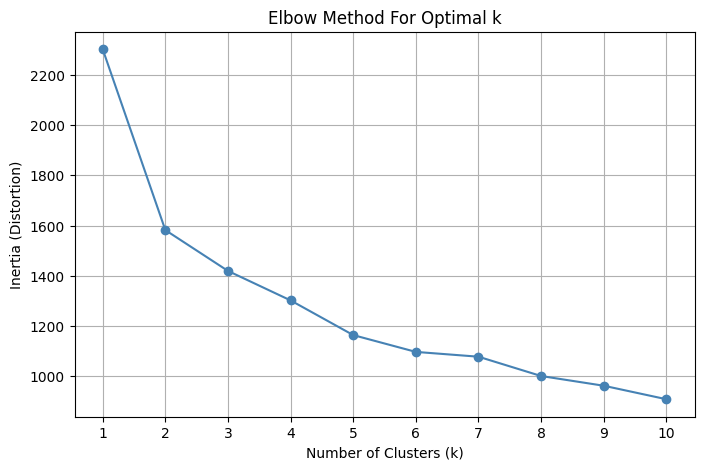

In [ ]:
# Extract features from the data
features = extract_features(data, labels)

X = features.drop(columns=["label"], errors="ignore")

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

elbow_method(X_scaled, max_clusters=10, distance_metric="euclidean")

"""
The optimal k differs from clustering raw time series because feature extraction summarizes temporal patterns.
Engineered features remove noise and reduce dimensionality, which may improve interpretability but lose granularity.
"""

## Exercise 4.6: Advanced 3D Visualization

Visualize the clustering results using interactive 3D plots with Plotly.

1. Use PCA to reduce the dimensionality of our feature space to 3 components
2. Create two visualizations:
   - Points colored by assigned cluster
   - Same points colored by actual quality labels
3. Include the explained variance for each principal component in the axis labels
4. Save the figures to the plot_path


This visualization will help us understand how well our clustering approach aligns with the known quality designations.

#### Note:
- You can use the following links to find more information about the PCA:
   - https://en.wikipedia.org/wiki/Principal_component_analysis
   - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [44]:
n_clusters = 6
kmeans = MyKMeans(n_clusters)
cluster_labels = kmeans.fit_predict(scaler.fit_transform(data.reshape(data.shape[0], -1)))


# Apply PCA to reduce dimensionality to 3 components for visualization
# PCA finds the directions of maximum variance in the data
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

# Extract explained variance ratios for informative axis labels
explained_variance = pca.explained_variance_ratio_

# Create axis labels including explained variance
axis_labels = {
    'x': f'PC1 ({explained_variance[0]:.1%} variance)',
    'y': f'PC2 ({explained_variance[1]:.1%} variance)', 
    'z': f'PC3 ({explained_variance[2]:.1%} variance)'
}

# Prepare data for visualization
df_viz = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1], 
    'PC3': X_pca[:, 2],
    'Cluster': [f'Cluster {int(label)}' for label in cluster_labels],
    'Quality': [f'Quality {int(label)}' for label in labels],
    'Cluster_Numeric': cluster_labels,
    'Quality_Numeric': labels
})

# Create color palettes
cluster_colors = px.colors.qualitative.Set1[:n_clusters]
quality_colors = px.colors.qualitative.Set2[:len(np.unique(labels))]

# Figure 1: Points colored by assigned clusters
fig1 = px.scatter_3d(
    df_viz, 
    x='PC1', y='PC2', z='PC3',
    color='Cluster',
    color_discrete_sequence=cluster_colors,
    title=f'3D Clustering Results - {n_clusters} Clusters<br><sub>Points colored by assigned cluster</sub>',
    labels=axis_labels,
    hover_data={
        'PC1': ':.3f',
        'PC2': ':.3f', 
        'PC3': ':.3f',
        'Cluster': True,
        'Quality': True  # Show actual quality in hover for comparison
    }
)

# Enhance the clustering visualization
fig1.update_traces(
    marker=dict(
        size=4,
        opacity=0.7,
        line=dict(width=0.5, color='white')  # Add subtle borders for clarity
    )
)

fig1.update_layout(
    scene=dict(
        xaxis_title=axis_labels['x'],
        yaxis_title=axis_labels['y'],
        zaxis_title=axis_labels['z'],
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
    ),
    font=dict(size=12),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left", 
        x=0.01
    ),
    width=800,
    height=600
)

# Figure 2: Same points colored by actual quality labels
fig2 = px.scatter_3d(
    df_viz,
    x='PC1', y='PC2', z='PC3', 
    color='Quality',
    color_discrete_sequence=quality_colors,
    title=f'3D Quality Distribution - Ground Truth Labels<br><sub>Same data points colored by actual quality</sub>',
    labels=axis_labels,
    hover_data={
        'PC1': ':.3f',
        'PC2': ':.3f',
        'PC3': ':.3f', 
        'Cluster': True,  # Show assigned cluster in hover for comparison
        'Quality': True
    }
)

# Apply consistent styling to quality visualization
fig2.update_traces(
    marker=dict(
        size=4,
        opacity=0.7,
        line=dict(width=0.5, color='white')
    )
)

fig2.update_layout(
    scene=dict(
        xaxis_title=axis_labels['x'],
        yaxis_title=axis_labels['y'], 
        zaxis_title=axis_labels['z'],
        camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))  # Match camera angle
    ),
    font=dict(size=12),
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    ),
    width=800,
    height=600
)

# Save the interactive figures
fig1_save_path = save_plotly_figure_as_html(fig1, plot_path / f'clusters_3d_{n_clusters}_clusters')
fig2_save_path = save_plotly_figure_as_html(fig2, plot_path / f'quality_3d_{n_clusters}_clusters')

# Display the figures
fig1.show()
fig2.show()

# Calculate and display clustering alignment metrics
print(f"\nClustering Alignment Analysis:")
print(f"Adjusted Rand Index: {adjusted_rand_score(labels, cluster_labels):.3f}")


Fitting:  17%|█▋        | 17/100 [00:00<00:02, 31.34it/s]



Clustering Alignment Analysis:
Adjusted Rand Index: 0.112


## Exercise 4.7: Analysis and Interpretation

Analyze the clustering results in depth and discuss their implications:

1. Cluster separation:
   - How well do clusters separate different quality levels?
   - What is the Adjusted Rand Index between clusters and quality labels?
   - Are there clusters that predominantly contain good or bad welds?

2. Feature importance:
   - Which features seem most important for distinguishing clusters?
   - How does the PCA visualization help us understand the data structure?

3. Process insights:
   - What insights could these clusters provide for improving the welding process?
   - Could certain clusters identify specific types of welding issues?

4. Limitations:
   - What are the limitations of using clustering for quality assessment?
   - How might the approach be improved in future iterations?

